In [45]:
print(__doc__)
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import Ridge
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import median_absolute_error

from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold

Automatically created module for IPython interactive environment


In [5]:
survey = fetch_openml(data_id=534, as_frame=True)
X = survey.data[survey.feature_names]

In [6]:
X.describe(include="all")

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,AGE,RACE,OCCUPATION,SECTOR,MARR
count,534.000000,534,534,534.000000,534,534.000000,534,534,534,534
unique,NaN,2,2,NaN,2,NaN,3,6,3,2
top,NaN,no,male,NaN,not_member,NaN,White,Other,Other,Married
freq,NaN,378,289,NaN,438,NaN,440,156,411,350
mean,13.018727,NaN,NaN,17.822097,NaN,36.833333,NaN,NaN,NaN,NaN
std,2.615373,NaN,NaN,12.379710,NaN,11.726573,NaN,NaN,NaN,NaN
min,2.000000,NaN,NaN,0.000000,NaN,18.000000,NaN,NaN,NaN,NaN
25%,12.000000,NaN,NaN,8.000000,NaN,28.000000,NaN,NaN,NaN,NaN
50%,12.000000,NaN,NaN,15.000000,NaN,35.000000,NaN,NaN,NaN,NaN
75%,15.000000,NaN,NaN,26.000000,NaN,44.000000,NaN,NaN,NaN,NaN


In [7]:
X.head()

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,AGE,RACE,OCCUPATION,SECTOR,MARR
0,8.0,no,female,21.0,not_member,35.0,Hispanic,Other,Manufacturing,Married
1,9.0,no,female,42.0,not_member,57.0,White,Other,Manufacturing,Married
2,12.0,no,male,1.0,not_member,19.0,White,Other,Manufacturing,Unmarried
3,12.0,no,male,4.0,not_member,22.0,White,Other,Other,Unmarried
4,12.0,no,male,17.0,not_member,35.0,White,Other,Other,Married


In [10]:
# target for prediction is wealth
y = survey.target.values.ravel()
survey.target.head()

0    5.10
1    4.95
2    6.67
3    4.00
4    7.50
Name: WAGE, dtype: float64

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

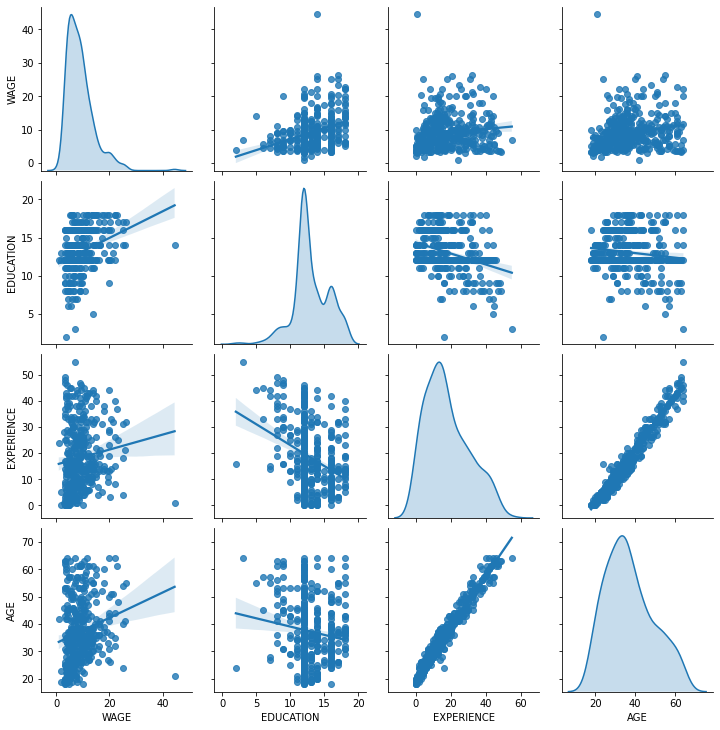

In [13]:
train_dataset = X_train.copy()
train_dataset.insert(0, "WAGE", y_train)
_= sns.pairplot(train_dataset, kind='reg', diag_kind='kde')

In [14]:
# check the type of data
survey.data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 534 entries, 0 to 533
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   EDUCATION   534 non-null    float64 
 1   SOUTH       534 non-null    category
 2   SEX         534 non-null    category
 3   EXPERIENCE  534 non-null    float64 
 4   UNION       534 non-null    category
 5   AGE         534 non-null    float64 
 6   RACE        534 non-null    category
 7   OCCUPATION  534 non-null    category
 8   SECTOR      534 non-null    category
 9   MARR        534 non-null    category
dtypes: category(7), float64(3)
memory usage: 17.1 KB


In [19]:
categorical_columns = ['RACE', 'OCCUPATION', 'SECTOR',
                       'MARR', 'UNION', 'SEX', 'SOUTH']
numerical_columns = ['EDUCATION', 'EXPERIENCE', 'AGE']

preprocessor = make_column_transformer(
    (OneHotEncoder(drop="if_binary"), categorical_columns), remainder='passthrough'
)

In [25]:
# We use ridge regressor as a linear model with a very small regularization
model = make_pipeline(preprocessor, TransformedTargetRegressor(
    regressor=Ridge(alpha=1e-10),
    func=np.log10,
    inverse_func=sp.special.exp10
))

_ = model.fit(X_train, y_train)

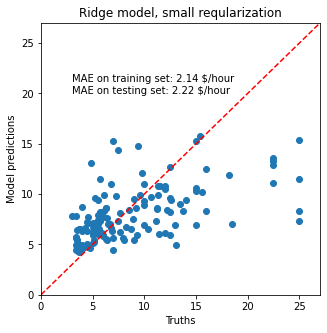

In [27]:
y_pred = model.predict(X_train)
mae = median_absolute_error(y_train, y_pred)
string_score = f'MAE on training set: {mae:.2f} $/hour'
y_pred = model.predict(X_test)
mae = median_absolute_error(y_test, y_pred)
string_score += f'\nMAE on testing set: {mae:.2f} $/hour'
fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(y_test, y_pred)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")
plt.text(3, 20, string_score)
plt.title("Ridge model, small reqularization")
plt.ylabel('Model predictions')
plt.xlabel('Truths')
plt.xlim([0, 27])
_ = plt.ylim([0, 27])

In [31]:
#  interpreting the coefficients
feature_names = (model.named_steps['columntransformer']
                     .named_transformers_['onehotencoder']
                     .get_feature_names(input_features=categorical_columns))
feature_names = np.concatenate([feature_names, numerical_columns])

coefs = pd.DataFrame(model.named_steps['transformedtargetregressor'].regressor_.coef_, 
                    columns = ['Coefficients'], index=feature_names)
coefs

,Coefficients
RACE_Hispanic,-0.013555
RACE_Other,-0.009111
RACE_White,0.022558
OCCUPATION_Clerical,0.000056
OCCUPATION_Management,0.090539
OCCUPATION_Other,-0.025091
OCCUPATION_Professional,0.071975
OCCUPATION_Sales,-0.046625
OCCUPATION_Service,-0.091042
SECTOR_Construction,-0.000177


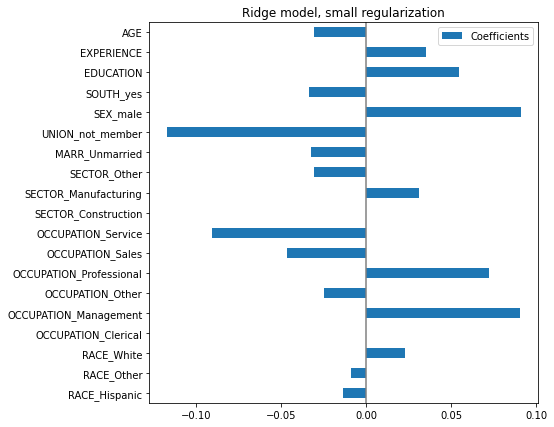

In [33]:
coefs.plot(kind="barh", figsize=(9, 7))
plt.title('Ridge model, small regularization')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

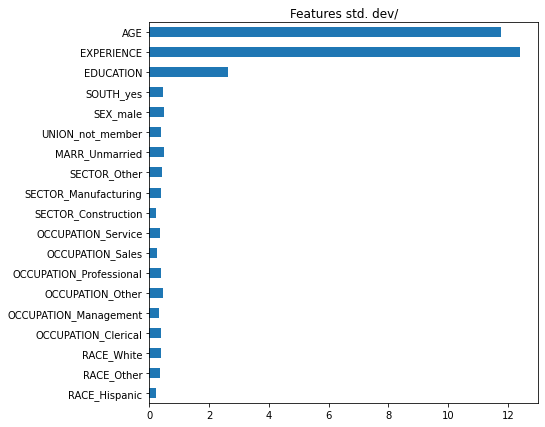

In [35]:
X_train_preprocessed = pd.DataFrame(model.named_steps['columntransformer'].transform(X_train), columns=feature_names)

X_train_preprocessed.std(axis=0).plot(kind='barh', figsize=(9, 7))
plt.title('Features std. dev/')
plt.subplots_adjust(left=.3)

Multiplying the coefficients by the standard deviation of the related feature would reduce all the coefficients to the same unit of measure. this is equivalent to normalizing the numerical variables to their standard deviation.
In that way the greator the variance of a feature, the larger the weight of the coresponding coefficient on the output, all else being equal.

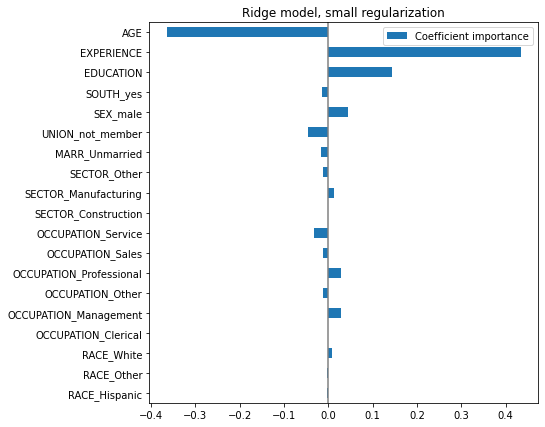

In [39]:
coefs = pd.DataFrame(
    model.named_steps['transformedtargetregressor'].regressor_.coef_*
    X_train_preprocessed.std(axis=0),
    columns=['Coefficient importance'], index=feature_names
)

coefs.plot(kind='barh', figsize=(9, 7))
plt.title('Ridge model, small regularization')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

Checking the variability of the coefficients
We can check the variability of the coefficients through cross validation.
It is a form of data perubation related to sampling

If coefficients vary significanltly when changing the input dataset, their robustness is not guaranteed and they should probably be interpreted with caution

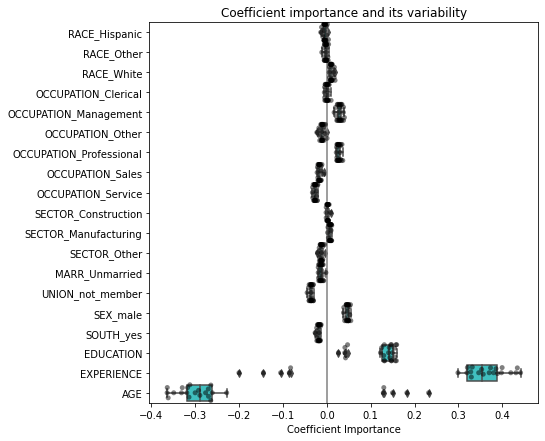

In [49]:
cv_model = cross_validate(
    model, X, y, cv=RepeatedKFold(n_splits=5, n_repeats=5),
    return_estimator=True, n_jobs=-1
)


coefs = pd.DataFrame(
    [est.named_steps['transformedtargetregressor'].regressor_.coef_*
    X_train_preprocessed.std(axis=0) for est in cv_model['estimator']],
    columns=feature_names
)

plt.figure(figsize=(9, 7))
sns.swarmplot(data=coefs, orient='h', color='k', alpha=0.5)
sns.boxplot(data=coefs, orient='h', color='cyan', saturation=0.5)
plt.axvline(x=0, color='.5')
plt.xlabel('Coefficient Importance')
plt.title('Coefficient importance and its variability')
plt.subplots_adjust(left=.3)

The problem of correlated variables

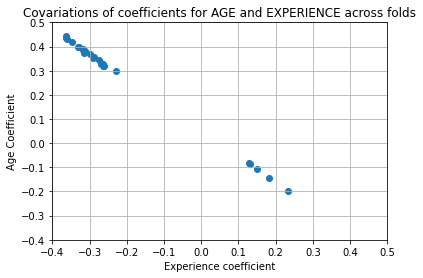

In [52]:
plt.ylabel('Age Coefficient')
plt.xlabel('Experience coefficient')
plt.grid(True)
plt.xlim(-0.4, 0.5)
plt.ylim(-0.4, 0.5)
plt.scatter(coefs['AGE'], coefs['EXPERIENCE'])
_ = plt.title('Covariations of coefficients for AGE and EXPERIENCE across folds')


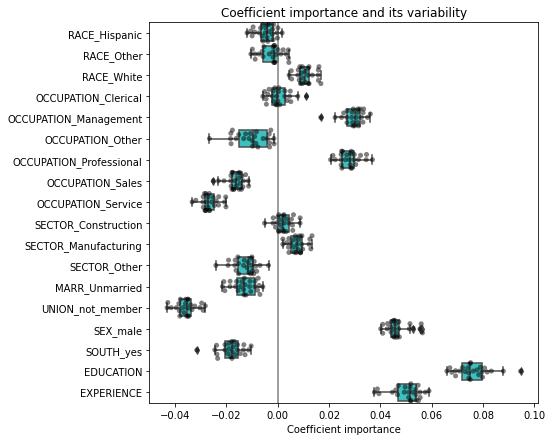

In [57]:
# To resolve the conflict, we remove one of the 2 featurs and check what is the impact on the model stability

column_to_drop = ['AGE']

cv_model = cross_validate(
    model, X.drop(columns=column_to_drop), y,
    cv=RepeatedKFold(n_splits=5, n_repeats=5),
    return_estimator=True, n_jobs=-1
)

coefs = pd.DataFrame(
    [est.named_steps['transformedtargetregressor'].regressor_.coef_ *
     X_train_preprocessed.drop(columns=column_to_drop).std(axis=0)
     for est in cv_model['estimator']],
    columns=feature_names[:-1]
)
plt.figure(figsize=(9, 7))
sns.swarmplot(data=coefs, orient='h', color='k', alpha=0.5)
sns.boxplot(data=coefs, orient='h', color='cyan', saturation=0.5)
plt.axvline(x=0, color='.5')
plt.title('Coefficient importance and its variability')
plt.xlabel('Coefficient importance')
plt.subplots_adjust(left=.3)

### Linear models with regularization
In machine learning practive, Ridge Ridgression is often used with non-negligible regularization
Above, we limited this regularization to a very little amount.
Regularization improves the conditioning of the problem and reduces the variace of the estimates.
RidgeCV applies cross validation in order to determine which value of the regularization parameter (alpha) is the best for prediction


In [71]:
from sklearn.linear_model import RidgeCV
model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=RidgeCV(alphas=np.logspace(-10, 10, 21)),
        func=np.log10,
        inverse_func=sp.special.exp10
    )
)

_ = model.fit(X_train, y_train)

In [72]:
# first check which value of alpha has been selected
model[-1].regressor_.alpha_

10.0

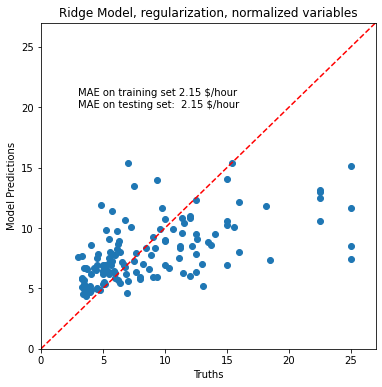

In [73]:
# then we check the quality of the predictions

y_pred = model.predict(X_train)
mae = median_absolute_error(y_train, y_pred)
string_score = f'MAE on training set {mae:.2f} $/hour'
y_pred = model.predict(X_test)
me = median_absolute_error(y_test, y_pred)
string_score += f'\nMAE on testing set: {mae: .2f} $/hour'

fig, ax = plt.subplots(figsize=(6, 6))
plt.scatter(y_test, y_pred)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c='red')
plt.text(3, 20, string_score)
plt.title('Ridge Model, regularization, normalized variables')
plt.ylabel('Model Predictions')
plt.xlabel('Truths')
plt.xlim([0, 27])
_ = plt.ylim([0, 27])

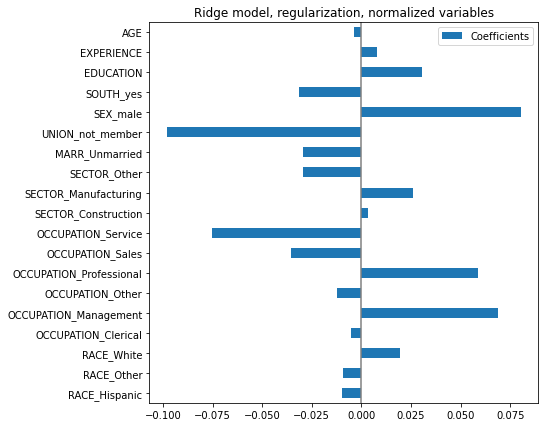

In [74]:
coefs = pd.DataFrame(
    model.named_steps['transformedtargetregressor'].regressor_.coef_,
    columns=['Coefficients'], index=feature_names
)

coefs.plot(kind='barh', figsize=(9, 7))
plt.title('Ridge model, regularization, normalized variables')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

The coefficients are significantly different. AGE and EXPERIENCE coefficients are both positive but they now have less influence on the prediction.

The regularization reduces the influence of correlated variables on the model because the weight is shared between the two predictive variables, so neither alone would have strong weights.

On the other hand, the weights obtained with regularization are more stable (see the Ridge regression and classification User Guide section). This increased stability is visible from the plot, obtained from data perturbations, in a cross validation. This plot can be compared with the previous one.

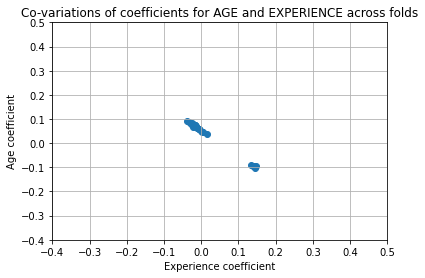

In [75]:
cv_model = cross_validate(
    model, X, y, cv=RepeatedKFold(n_splits=5, n_repeats=5),
    return_estimator=True, n_jobs=-1
)
coefs = pd.DataFrame(
    [est.named_steps['transformedtargetregressor'].regressor_.coef_ *
     X_train_preprocessed.std(axis=0)
     for est in cv_model['estimator']],
    columns=feature_names
)

plt.ylabel('Age coefficient')
plt.xlabel('Experience coefficient')
plt.grid(True)
plt.xlim(-0.4, 0.5)
plt.ylim(-0.4, 0.5)
plt.scatter(coefs["AGE"], coefs["EXPERIENCE"])
_ = plt.title('Co-variations of coefficients for AGE and EXPERIENCE '
              'across folds')

### Linear models with sparse coefficients

Another posibililty to take into account correlated variable in the dataset, is to estimate sparse coefficients.

Lasso models estimates sparse coefficients. LassoCV applies cross validation in order to determin which value of the regularization parameter(alpha) is best suited for the model estimation

In [66]:
from sklearn.linear_model import LassoCV

model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=LassoCV(alphas=np.logspace(-10, 10, 21), max_iter=100000),
        func=np.log10,
        inverse_func=sp.special.exp10
    )
)

_ = model.fit(X_train, y_train)
model[-1].regressor_.alpha_

0.001

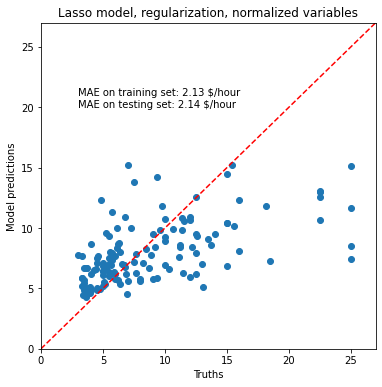

In [67]:
y_pred = model.predict(X_train)
mae = median_absolute_error(y_train, y_pred)
string_score = f'MAE on training set: {mae:.2f} $/hour'
y_pred = model.predict(X_test)
mae = median_absolute_error(y_test, y_pred)
string_score += f'\nMAE on testing set: {mae:.2f} $/hour'

fig, ax = plt.subplots(figsize=(6, 6))
plt.scatter(y_test, y_pred)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")

plt.text(3, 20, string_score)

plt.title('Lasso model, regularization, normalized variables')
plt.ylabel('Model predictions')
plt.xlabel('Truths')
plt.xlim([0, 27])
_ = plt.ylim([0, 27])

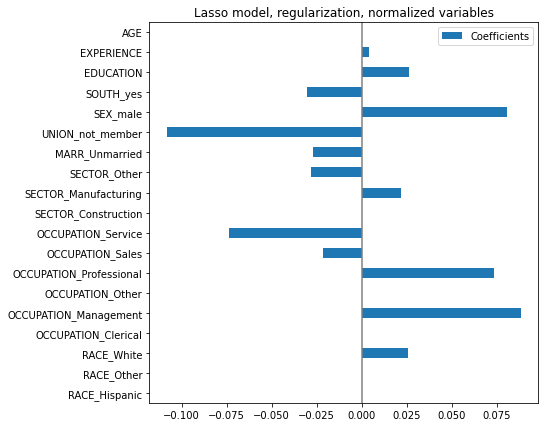

In [68]:
coefs = pd.DataFrame(
    model.named_steps['transformedtargetregressor'].regressor_.coef_,
    columns=['Coefficients'], index=feature_names
)
coefs.plot(kind='barh', figsize=(9, 7))
plt.title('Lasso model, regularization, normalized variables')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

## Lessons Learned
Coefficients must be scaled to the same unit of measure to retrieve feature importance. Scaling them with the standard-deviation of the feature is a useful proxy.

Coefficients in multivariate linear models represent the dependency between a given feature and the target, conditional on the other features.

Correlated features induce instabilities in the coefficients of linear models and their effects cannot be well teased apart.

Different linear models respond differently to feature correlation and coefficients could significantly vary from one another.

Inspecting coefficients across the folds of a cross-validation loop gives an idea of their stability.